# MagGeo - Parallel Mode 

**Authors** | Fernando Benitez-Paez, Urška Demšar, Jed Long, Ciaran Beggan

**Contact**  | [Fernando.Benitez@st-andrews.ac.uk](mailto:Fernando.Benitez@st-andrews.ac.uk), [ud2@st-andrews.ac.uk](mailto:ud2@st-andrews.ac.uk), [jed.long@uwo.ca](mailto:jed.long@uwo.ca), [ciar@bgs.ac.uk](mailto:Fernando.Benitez@st-andrews.ac.uk)

**nbviewer URL** | https://nbviewer.jupyter.org/github/MagGeo/MagGeo-Annotation-Program/blob/master/MagGeo%20-%20Parallel%20Mode.ipynb

**Keywords** | Bird migration, data fusion, Earth’s magnetic field, Swarm, GPS tracking

## Overview

This Jupyter Notebook will guide you through the required steps to annotate your GPS tracking data with the earth's magnetic field data from Swarm (European Space Agency). This version is called Parallel Mode to take advantage of parallelized computing to process big datasets.

To execute the code, you can go through each cell (pressing <code>Crtl+Enter</code>), you will also find inner comments `##` to describe each particular step. If you are not familiar with Jupyter Notebook, you migth want to take some time to learn how to use it first, for example take a look at the <code>notebook-basics.ipynb</code> Notebook inside MagGeo.

**For parallel processing, there are some considerations to make:**

1. Linux and Windows environments have some differences. In windows we need to separate the functions and store them separately, then import them into a `main` function. 
3. Defining what part of the process is <strong>CPU bound</strong> and what part is <strong>I/O bound</strong>: Identify what parts of the program are I/O bound (writing or reading from the disk or network) and what part par CPU bound ( Processing capacity). To take advantage of our CPU capacity we need to identify the process where the CPU is actually doing the main Tasks.

## Data requirements


<div class="alert alert-warning" role="alert">
  <strong>🔎 Your trajectory must be in a csv format:</strong>

There are three columns that  must be included in your GPS trajectory. Make sure your GPS trajectory includes  **Latitude** , **Longitude** and **timestamp**. We suggest that the Timestamp column follow the day/month/year Hour:Minute (**dd/mm/yyyy HH:MM:SS**) format, Latitude and Longitude should be in decimal degrees (WGS84). Optionally an altitude column can be used providing altitude (the altitude must be in **km**). Other Columns will be ignored. Here it is an example of how your GPS track should look:

<img src="./images/TableExample.png">

For this example we are reading the <strong>BirdGPSTrajectory.csv</strong> file. If you want to run the method using your own csv file, make sure you store your the file in the <code>./data</code> folder. For more information about the dataset we used in this example go to the Main Notebook.
</div>

## Import the requeried libraries

In [1]:
import datetime as dt
import sys,os
from pathlib import Path
import pandas as pd
import numpy as np
import datetime, time
from datetime import timedelta
import math
import pathlib
from datetime import datetime
import time
import calendar
import datetime
from viresclient import ClientConfig
import matplotlib.pyplot as plt

## Add your VirES web client Token

The **VirES client API**, requires a token. Before start you need to get your own VirES token. You can visit https://vires.services/ to get yours, and then add it into the next cell.

In [22]:
VirESToken = "Add your Token Here"

## Reading the GPS track

The following steps will load the GPS track from a csv file, and set some requirements before download the data from Swarm.
Importing the GPS track. You can note that there is a folder to store the CSV file. Using `os.getcwd()` you can validate where the file is located.

In [3]:
#Enter the name of your GPS track csv file including the extension .csv  and press Enter (e.g. BirdGPSTrajectory.csv)
gpsfilename=input("What is the name of your .csv file?: ")
Lat=input("Enter the name of your Latitude column?: ")
Long=input("Enter the name of your Longitud column?: ")
DateTime=input("Enter the date and time column name?: ")
altitude = input("Enter the Altitude column name?, if you dont have it just press Enter:")
#If you csv track file doesnt not have any altitude attribute, MagGeo will use the sea level as your altitude, means 0 Km.

What is the name of your .csv file?: BirdGPSTrajectory.csv
Enter the name of your Latitude column?: location-lat
Enter the name of your Longitud column?: location-long
Enter the date and time column name?: timestamp
Enter the Altitude column name?, if you dont have it just press Enter:


In [4]:
os.chdir(r"./data")
def getGPSData():
    if altitude == '':
        nfp = pd.read_csv(gpsfilename, parse_dates=[0], encoding='utf-8', dayfirst=True, usecols=[Lat, Long, DateTime])
        nfp['gpsAltitude'] = 0
    else:
        nfp = pd.read_csv(gpsfilename, parse_dates=[0], encoding='utf-8', dayfirst=True, usecols=[Lat, Long, DateTime, altitude])
    return nfp

In [5]:
# Calling the previous function to get the track as pandas Dataframe and renaming the columns for better experience.
GPSData = getGPSData()
GPSData.rename(columns={Lat: 'gpsLat', Long: 'gpsLong', DateTime: 'gpsDateTime', altitude: 'gpsAltitude'}, inplace = True)
GPSData.head()

,gpsDateTime,gpsLong,gpsLat,gpsAltitude
0,2014-09-08 05:54:00,68.307333,70.854717,0
1,2014-09-08 06:10:00,67.975050,70.830300,0
2,2014-09-08 06:26:00,67.752417,70.761717,0
3,2014-09-08 06:42:00,67.561983,70.686517,0
4,2014-09-08 07:14:00,67.548317,70.685450,0


Setting the date and time attributes for the requerided format and computing the epoch column. Values like Maximum and Minimun Date and time are also calculated.

In [6]:
# Convert the gpsDateTime to datetime python object
GPSData['gpsDateTime'] = pd.to_datetime(GPSData['gpsDateTime'], format='%d/%m/%Y %H:%M')
GPSData['gpsDateTime'] = GPSData['gpsDateTime'].map(lambda x: x.replace(second=0))
GPSData['gpsLat'] = GPSData['gpsLat'].astype(float)
GPSData['gpsLong'] = GPSData['gpsLong'].astype(float)
#Adding new column epoch, will be usefuel to compare the date&time o each gps point againts the gathered swmarm data points
GPSData['epoch'] = GPSData['gpsDateTime'].astype('int64')//1e9
GPSData['epoch'] = GPSData['epoch'].astype(int)
#Computing Date and Time columns
GPSData['dates'] = GPSData['gpsDateTime'].dt.date
GPSData['times'] = GPSData['gpsDateTime'].dt.time
#Maximum and Minimum values
MinDateTime = min(GPSData['gpsDateTime'])
MaxDateTime = max(GPSData['gpsDateTime'])
dt_object1 = MinDateTime.to_pydatetime()
dt_object2 = MaxDateTime.to_pydatetime()
startDate = MinDateTime.date()
endDate = MaxDateTime.date()
MinTime=MinDateTime.time()
MaxTime=MaxDateTime.time()
GPSData.head()

,gpsDateTime,gpsLong,gpsLat,gpsAltitude,epoch,dates,times
0,2014-09-08 05:54:00,68.307333,70.854717,0,1410155640,2014-09-08,05:54:00
1,2014-09-08 06:10:00,67.975050,70.830300,0,1410156600,2014-09-08,06:10:00
2,2014-09-08 06:26:00,67.752417,70.761717,0,1410157560,2014-09-08,06:26:00
3,2014-09-08 06:42:00,67.561983,70.686517,0,1410158520,2014-09-08,06:42:00
4,2014-09-08 07:14:00,67.548317,70.685450,0,1410160440,2014-09-08,07:14:00


## Validate the right amount of Swarm measures

The following loop is identifiying the time and validating if the time is less than 4:00 hours and more than 20:00 hours to bring one extra day of data. The result of this validation is written in a empty python list which will be later validated to get the unique dates avoing to download data for the same day and reducing the the downloand time process.

In [7]:
datestimeslist = []
for index, row in GPSData.iterrows():
    datetimerow  = row['gpsDateTime']
    daterow = row['dates']
    hourrow = row['times']
    hourrow = hourrow.strftime('%H:%M:%S')
    if hourrow < '04:00:00':
        date_bfr = daterow - (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(date_bfr)
    if hourrow > '20:00:00':
        Date_aft = daterow + (timedelta(days=1))
        datestimeslist.append(daterow)
        datestimeslist.append(Date_aft)  
    else:
        datestimeslist.append(daterow)

Getting a list of unique dates, to being used to download the Swarm Data

In [ ]:
def uniquelistdates(list): 
    x = np.array(list) 
    uniquelist = np.unique(x)
    return uniquelist

uniquelist_dates = uniquelistdates(datestimeslist)
uniquelist_dates

## Download Swarm residuals data

Once the date and time columns have been defined, and the unique dates were identified the script can start the download process. Usually the data from Swarm is requested using only one satellite, however **MagGeo** will use the magnetic measures from the three satellite of the Swarm Mission.

<div class="alert alert-info" role="alert">
📘 <strong>Be aware:</strong> Due to the amount of dates the GPS track has (42 days) to request and compute the residuals, the time to process the sample data will take approximately 10 minutes.</div>

Set a connection to the <code>VirES client</code> and using the function <code>Get_Swarm_residuals</code> we will get the swarm residuals for the dates included in the previous list.

In [ ]:
%%time

from MagGeoFunctions import Get_Swarm_residuals

hours_t_day = 24
hours_added = datetime.timedelta(hours = hours_t_day)

listdfa = []
listdfb = []
listdfc = []

cc = ClientConfig()
cc.set_site_config("https://vires.services/ows", token=VirESToken)
cc.default_url = "https://vires.services/ows"
cc.save()

for d in uniquelist_dates:
    print("Process for:",d,":" )
    startdate = datetime.datetime.combine(d, datetime.datetime.min.time())
    enddate = startdate + hours_added
    SwarmResidualsA,SwarmResidualsB,SwarmResidualsC = Get_Swarm_residuals(startdate, enddate)
    listdfa.append(SwarmResidualsA)
    listdfb.append(SwarmResidualsB)
    listdfc.append(SwarmResidualsC)

Integrate the previous list for all dates, into pandas dataframes

In [10]:
TotalSwarmRes_A = pd.concat(listdfa, join='outer', axis=0)
TotalSwarmRes_B = pd.concat(listdfb, join='outer', axis=0)
TotalSwarmRes_C = pd.concat(listdfc, join='outer', axis=0)
TotalSwarmRes_A.head()

,Radius,Kp,Longitude,F_res_CHAOS_MCO_MLI_MMA,Spacecraft,Latitude,N_res,E_res,C_res,timestamp
epoch,,,,,,,,,,
1408320000,6832723.53,1.0,-134.672531,6.514502,A,66.843847,-2.818325,9.260076,6.498977,2014-08-18 00:00:00
1408320060,6832377.42,0.7,-133.562740,2.395450,A,70.654918,-29.732619,34.448506,4.319175,2014-08-18 00:01:00
1408320120,6832096.43,0.7,-131.817227,-6.841385,A,74.451293,-72.881573,62.656630,-3.129330,2014-08-18 00:02:00
1408320180,6831883.56,0.7,-128.828006,-13.353861,A,78.218581,-149.117239,86.436650,-8.007169,2014-08-18 00:03:00
1408320240,6831741.03,0.7,-122.893911,-41.131992,A,81.915833,4.893830,2.873999,-41.353059,2014-08-18 00:04:00


## Write the requested data in Disk, to be used into the requeried functions
In Parallel mode we can not use a temporary results, therefore we need to store in disk the previous pandas dataframes in csv files.

In [11]:
TotalSwarmRes_A.to_csv ('TotalSwarmRes_A.csv', header=True)
TotalSwarmRes_B.to_csv ('TotalSwarmRes_B.csv', header=True)
TotalSwarmRes_C.to_csv ('TotalSwarmRes_C.csv', header=True)

## Set the number of processes, and split the dataframe (GPSData) into chunks

We can set the number or processess we need to dedicate for the multiprocessing mode, of course that also depends on the number of cores the machine you are using to run **MagGeo**. You can use `multiprocessing.cpu_count()` to set the number of processes as the the number of cores your machine has. Beside that we will also to split the GPS track into chucks to dedicate each core for each chuck.

In [ ]:
import multiprocessing
import sklearn
from multiprocessing import Pool

NumCores = multiprocessing.cpu_count()
df_chunks = np.array_split(GPSData,NumCores)
df_chunks

## Spatio-Temporal filter and Interpolation process (ST-IDW) 

Once we have requested the swarm data, now we need to `filter` in space and time the available points to compute the magnetic values (NEC frame) for each GPS point based on its particular date and time. The function <code>ST_IDW_Process</code> imported in the <code>row_handler</code>, takes the GPS track and the downloaded data from swarm to filter in space and time based on the criteria defined in our method. With the swarm data filtered we interpolated (IDW) the NEC components for each GPS data point, based on the latitude, date, time and number of Swarm points filtered.

The function <code>CHAOS_ground_values</code>, inside the <code>MagGeoFunctions</code> file, is used to run the **ionospheric correction**. This correction requeries the magnetic components at the ground level using CHAOS (theta, phi, radial). This process include a rotation and transformation between a geocentric frame (CHAOS) and geodetic frame (GPS track). Once the corrected values are calculated, are included in the GPS track, and the non-necesary columns are removed. For more information about this process go to the Main Notebook.


## Run the process in parallel mode

Although the next cell seems to run a small `main` function.  What is happening is a call for several functions running at same time for several cores. Initially we set a pool of processes. Using the `pool` class we will distribute the assigned function among the data chucks we created. Every data chunk will be like a subset of the entire GPS track. So we need to iterate among data chunk. And inside every data chunk we need to identify the `datetime`, `epoch`, `altitude`, `latitude` and `longitude` of each row to run the interpolation & annotation process using the Swarm data we have filtered and stored in the previous steps.

The function in charge to distribute the required function (`row_handler`) among the data chunks is the map function from the `pool` class. 

`row_handler.py` is an interows iteration to get the required parameter for the `ST_IDW_Process` function. 

<div class="alert alert-info" role="alert">
<strong>📘 Auxiliary Functions:</strong>
 
<ol>
  <li><strong>ST_IDW_Process</strong> function: This is the main function in charge to read the Swarm Data already filtered, and then import  <code>DfTime_func</code>,  <code>distance_to_GPS</code>, <code>Kradius</code> , <code>DistJ</code> functions to compute the spatial-time cylinder and the annotation process. The return of this function is a row (dictionary) that will be appended into a python list where all the results from the different cores. The python list from every process is concatenated into a pandas dataframe in the <code>main</code> function having there the whole chain of the parallel process.</li>
  <li><strong>distance_to_GPS</strong> function: Is the function in charge to calculate the distance between each GPS Point and the Swarm Point.</li>
  <li><strong>Kradius</strong> function: Is the function in charge to compute the R (radius) value in the cylinder. The R value will be considered based on the latitude of each GPS Point.</li>
    <li><strong>DistJ</strong> function: This function will calculate the <code>d</code> value as the hypotenuse created in the triangle created amount the locations of the GPS point, the location of the Swarm points and the radius value.</li>
  <li><strong>DfTime_func</strong> function: This is a time function to selected the points in the range of a the DeltaTime - <code>DT</code> window. The Delta time window has been set as 4 hours for each satellite trajectory.</li>
  <li><strong>CHAOS_ground_values</strong> function: This is a ionospheric correction function to get the CHAOS magnetic values and process the Nres,Eres,Cres values and transform them into the N,E,C values at the GPS altitude.</li>
</ol> 

</div>


In [13]:
%%time
from functools import partial
import row_handler

if __name__ == '__main__':
    with multiprocessing.Pool(NumCores) as pool:
        GeoMagParallelResult = pd.concat(pool.map(partial(row_handler.row_handler), df_chunks), ignore_index=True)

Wall time: 18.7 s


With the Parallel mode the Annotation process takes about 12 seconds to complete ( We had tested the parallel process in a  windows server machine with 12 cores, see the image bellow). With the same GPS track in the sequetial mode the process is complete in about 2 minutes. In the image bellow you can see how the machine create several python processes and all cores (full CPU capacity) is taken.

<div class="alert alert-warning" role="alert">
<strong>🔈 Multiprocessing:</strong>

is even  more powerfull when you have to process a big amount of data (e.g. 2 millons of points). Although here is making a notable improvement if you have to process a big dataset the parallelization makes even more sense.

</div>

<img src="./images/CoresWorking.png" style="zoom: 100%;" >


##  The final result 

With the NEC components for each GPS Track point, it is possible to compute the aditional magnetic components. For more information about the magnetic components and their relevance go to the main paper or notebook.

<div class="alert alert-info" role="alert">
    <strong>📘 The annotated dataframe will include the following attributes:</strong> If you need more information about how the geomagnetic component are described go to the main MagGeo Notebook (Add Link).
    <ul>
      <li><strong>Latitude</strong> from the GPS Track.</li>
      <li><strong>Longitude</strong> from the GPS Track.</li>
      <li><strong>Timestamp</strong> from the GPS Track.</li>
      <li><strong>Magnetic Field Intensity</strong>  mapped as Fgps in nanoTeslas (nT).</li>
      <li><strong>N (Northwards) component</strong> mapped as N in nanoTeslas (nT).</li>
      <li><strong>E (Eastwards) component</strong> mapped as E. in nanoteslas (nT).</li>
      <li><strong>C (Downwards or Center)</strong> component mapped as C in nanoTeslas (nT).</li>
      <li><strong>Horizontal component</strong> mapped as H in nanoTeslas (nT).</li>
      <li><strong>Magnetic Inclination </strong> mapped as I in degrees.</li> 
      <li><strong>Magnetic Declination or dip angle</strong> mapped as D in degrees</li>
      <li><strong>Kp Index</strong> mapped as kp</li>
      <li><strong>Total Points</strong> as the amount of Swarm messuares included in the ST-IDW process from the trajectories requested in the three satellites.</li>
      <li><strong>Minimum Distance</strong> mapped as MinDist, representing the minimum distance amount the set of identified point inside the Space Time cylinder and each GPS point location.</li>
      <li><strong>Average Distance</strong> mapped as AvDist, representing the average distance amount the set of distances between the identified Swarm Point in the Space Time cylinder and the GPS Points location.</li>
    </ul>

</div> 

In [14]:
#14. Having Intepolated and weigth magnetic values, we can compute the other magnectic components. 
GeoMagParallelResult['H'] = np.sqrt((GeoMagParallelResult['N']**2)+(GeoMagParallelResult['E']**2))
#check the arcgtan in python., From arctan2 is saver.
DgpsRad = np.arctan2(GeoMagParallelResult['E'],GeoMagParallelResult['N'])
GeoMagParallelResult['D'] = np.degrees(DgpsRad)
IgpsRad = np.arctan2(GeoMagParallelResult['C'],GeoMagParallelResult['H'])
GeoMagParallelResult['I'] = np.degrees(IgpsRad)
GeoMagParallelResult['F'] = np.sqrt((GeoMagParallelResult['N']**2)+(GeoMagParallelResult['E']**2)+(GeoMagParallelResult['C']**2))
GeoMagParallelResult.head()

,Latitude,Longitude,Altitude,DateTime,TotalPoints,Minimum_Distance,Average_Distance,Kp,N,E,C,H,D,I,F
0,70.854717,68.307333,0,2014-09-08 05:54:00,21,327.950987,626.701218,1.319048,6950.195375,3846.562150,57704.463629,7943.629908,28.962187,82.161894,58248.659888
1,70.830300,67.975050,0,2014-09-08 06:10:00,21,340.038476,628.953831,1.319048,6987.096440,3863.738340,57656.841943,7984.233878,28.941803,82.115906,58207.039208
2,70.761717,67.752417,0,2014-09-08 06:26:00,26,348.223318,656.804069,1.200000,7036.412142,3876.893913,57623.804876,8033.766380,28.853707,82.063126,58181.133459
3,70.686517,67.561983,0,2014-09-08 06:42:00,26,355.472899,657.901776,1.200000,7084.031805,3887.799448,57596.417630,8080.748181,28.758495,82.013560,58160.517664
4,70.685450,67.548317,0,2014-09-08 07:14:00,26,355.980432,657.921513,1.200000,7086.600738,3887.382647,57594.425512,8082.799878,28.747143,82.011286,58158.829974


## Validate the results
To validate the results we plot the `F`column.

In [15]:
## Creating a copy of the results and setting the Datetime Column as dataframe index.
ValidateDF = GeoMagParallelResult.copy()
ValidateDF.set_index("DateTime", inplace=True)

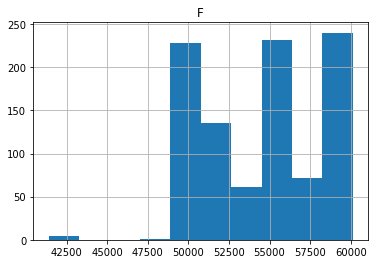

In [16]:
## Plotting the F column.
import matplotlib.pyplot as plt
hist = ValidateDF.hist(column='F')

## Optional: Map the GPS Track using the annotated Magnetic Values

Now we are going to plot the annotated GPS track stored into the MagDataFinal dataframe to see how the different magnetic components in a map to have a better prespective of the impact of the earth magnetic field.

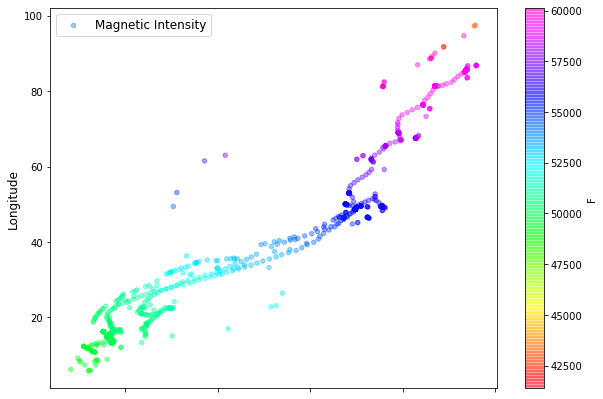

In [17]:
import matplotlib.pyplot as plt

ValidateDF.plot(kind="scatter", x="Latitude", y="Longitude",
    label="Magnetic Intensity",
    c="F", cmap=plt.get_cmap("gist_rainbow"),
    colorbar=True, alpha=0.4, figsize=(10,7)
    
)

plt.ylabel("Longitude", fontsize=12)
plt.xlabel("Latitude", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [18]:
import geopandas
import geoplot
gdf = geopandas.GeoDataFrame(ValidateDF, geometry=geopandas.points_from_xy(ValidateDF.Longitude, ValidateDF.Latitude))
gdf.head()

,Latitude,Longitude,Altitude,TotalPoints,Minimum_Distance,Average_Distance,Kp,N,E,C,H,D,I,F,geometry
DateTime,,,,,,,,,,,,,,,
2014-09-08 05:54:00,70.854717,68.307333,0,21,327.950987,626.701218,1.319048,6950.195375,3846.562150,57704.463629,7943.629908,28.962187,82.161894,58248.659888,POINT (68.30733 70.85472)
2014-09-08 06:10:00,70.830300,67.975050,0,21,340.038476,628.953831,1.319048,6987.096440,3863.738340,57656.841943,7984.233878,28.941803,82.115906,58207.039208,POINT (67.97505 70.83030)
2014-09-08 06:26:00,70.761717,67.752417,0,26,348.223318,656.804069,1.200000,7036.412142,3876.893913,57623.804876,8033.766380,28.853707,82.063126,58181.133459,POINT (67.75242 70.76172)
2014-09-08 06:42:00,70.686517,67.561983,0,26,355.472899,657.901776,1.200000,7084.031805,3887.799448,57596.417630,8080.748181,28.758495,82.013560,58160.517664,POINT (67.56198 70.68652)
2014-09-08 07:14:00,70.685450,67.548317,0,26,355.980432,657.921513,1.200000,7086.600738,3887.382647,57594.425512,8082.799878,28.747143,82.011286,58158.829974,POINT (67.54832 70.68545)


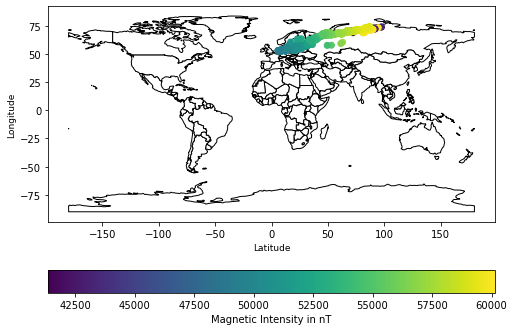

In [19]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize = (8,6))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, column='F', legend=True, 
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)

plt.show()

Text(567.7954545454544, 0.5, 'Longitude')

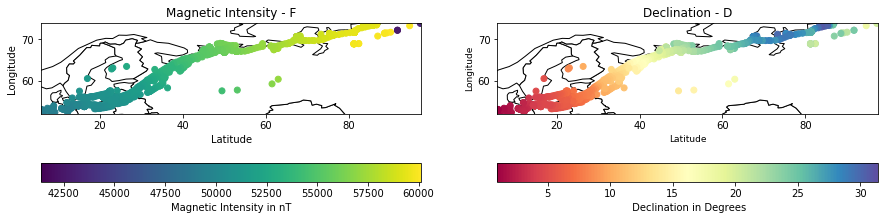

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,6))

ax1 = world.plot(ax=ax1, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)


gdf.plot(ax=ax1, column='F', legend=True,
         legend_kwds={'label': "Magnetic Intensity in nT",
                      'orientation': "horizontal"})
plt.ylabel("Longitude", fontsize=9)
plt.xlabel("Latitude", fontsize=9)
ax1.set_title('Magnetic Intensity - F')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')


ax2 = world.plot( ax=ax2, color='white', edgecolor='black')
xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)


# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax2, column='D', legend=True, cmap='Spectral', 
         legend_kwds={'label': " Declination in Degrees",
                      'orientation': "horizontal"})
ax2.set_title('Declination - D')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')

## Export the final results to a CSV file


In [21]:
#Exporting the CSV file
os.chdir(r"../results")
outputfile ="GeoMag_"+gpsfilename
export_csv = GeoMagParallelResult.to_csv (outputfile, index = None, header=True)